In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Ellipse

import plotly.express as px
import plotly.graph_objects as go

from itertools import combinations
from scipy import stats
from scipy.io import loadmat, whosmat
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from scipy.linalg import inv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from statsmodels.multivariate.manova import MANOVA

import pywt

import src
from src import config, loadmatNina
from src.preprocessing_utils import get_envelope

In [ ]:
# Choose the database to analyze
database = 'DB4'

data_path = f'data/{database}'

# Find the folder named with the convention s + "number"
folder = None
for item in os.listdir(data_path):
    if re.match(r'[sS]\d+', item) or re.match(r'Subject\d+', item):
        folder = item
        break

if folder:
    folder_path = os.path.join(data_path, folder)
    results = []

    # Iterate over all .mat files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mat'):
            file_path = os.path.join(folder_path, file_name)
            info = whosmat(file_path)
            results.append((file_name, info))

    # Create a DataFrame to store the results
    data = {}
    for file_name, info in results:
        for item in info:
            if item[0] not in data:
                data[item[0]] = {}
            data[item[0]][file_name] = item[1:]

    df = pd.DataFrame(data)
    df = df.transpose()
    df.columns.name = 'File Name'

    print(df)
else:
    print("No folder found with the convention s + 'number'")

## Functions

- For complete signal

In [ ]:
def calculate_emg_metrics(signal, fs=2000):
    """
    Calculates various metrics for an EMG signal.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    # Mean Absolute Value (MAV)
    mav = np.mean(np.abs(signal))
    
    # Integrated Absolute Value (IAV)
    iav = np.sum(np.abs(signal))
    
    # Root Mean Square (RMS)
    rms = np.sqrt(np.mean(signal**2))
    
    # Waveform Length (WL)
    wl = np.sum(np.abs(np.diff(signal)))
    
    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal)) != 0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal)
    ssc = np.sum((diff_signal[1:] * diff_signal[:-1]) < 0)
    
    # Variance (VAR)
    var = np.var(signal)
    
    # Coefficient of Variation (CoV)
    mean_signal = np.mean(signal)
    cov = (np.std(signal) / mean_signal) if mean_signal != 0 else 0
    
    # Mean Frequency (MNF)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    mnf = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Marginal Discrete Wavelet Transform (mDWT)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    mdwt = np.sum([np.sum(np.abs(c)) for c in coeffs])
    
    # Temporal Difference (TD)
    td = np.sum(np.abs(np.diff(signal)))
    
    # Mean Absolute Value Slope (MAVS)
    mavs = np.mean(np.abs(np.diff(signal)))
    
    # Return the metrics as a dictionary
    metrics = {
        "MAV": mav,
        "IAV": iav,
        "RMS": rms,
        "WL": wl,
        "ZC": zc,
        "SSC": ssc,
        "VAR": var,
        "CoV": cov,
        "MNF": mnf,
        "mDWT": mdwt,
        "TD": td,
        "MAVS": mavs
    }
    
    return metrics

In [ ]:
def calculate_emg_metrics_std(signal, fs=2000):
    """
    Calculates various metrics for an EMG signal, including mean and standard deviation.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    if signal.ndim == 2:
        metrics_per_channel = [calculate_emg_metrics(signal[:, ch], fs) for ch in range(signal.shape[1])]
        averaged_metrics = {key: np.mean([m[key] for m in metrics_per_channel]) for key in metrics_per_channel[0]}
        return averaged_metrics
    
    # Mean Absolute Value (MAV)
    mav = np.mean(np.abs(signal))
    mav_std = np.std(np.abs(signal))
    
    # Integrated Absolute Value (IAV)
    iav = np.sum(np.abs(signal))
    iav_std = np.std(np.abs(signal))
    
    # Root Mean Square (RMS)
    rms = np.sqrt(np.mean(signal**2))
    rms_std = np.std(signal)
    
    # Waveform Length (WL)
    wl = np.sum(np.abs(np.diff(signal)))
    wl_std = np.std(np.abs(np.diff(signal)))
    
    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal)) != 0)
    zc_std = np.std(np.diff(np.sign(signal)) != 0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal)
    ssc = np.sum((diff_signal[1:] * diff_signal[:-1]) < 0)
    ssc_std = np.std((diff_signal[1:] * diff_signal[:-1]) < 0)
    
    # Variance (VAR)
    var = np.var(signal)
    var_std = np.std(signal)
    
    # Coefficient of Variation (CoV)
    mean_signal = np.mean(signal)
    cov = (np.std(signal) / mean_signal) if mean_signal != 0 else 0
    cov_std = np.std(cov)
    
    # Mean Frequency (MNF)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    mnf = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    mnf_std = np.std(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Marginal Discrete Wavelet Transform (mDWT)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    mdwt = np.sum([np.sum(np.abs(c)) for c in coeffs])
    mdwt_std = np.std([np.sum(np.abs(c)) for c in coeffs])
    
    # Temporal Difference (TD)
    td = np.sum(np.abs(np.diff(signal)))
    td_std = np.std(np.abs(np.diff(signal)))
    
    # Mean Absolute Value Slope (MAVS)
    mavs = np.mean(np.abs(np.diff(signal)))
    mavs_std = np.std(np.abs(np.diff(signal)))
    
    # Return the metrics as a dictionary
    metrics = {
        "MAV": mav, "MAV_STD": mav_std,
        "IAV": iav, "IAV_STD": iav_std,
        "RMS": rms, "RMS_STD": rms_std,
        "WL": wl, "WL_STD": wl_std,
        "ZC": zc, "ZC_STD": zc_std,
        "SSC": ssc, "SSC_STD": ssc_std,
        "VAR": var, "VAR_STD": var_std,
        "CoV": cov, "CoV_STD": cov_std,
        "MNF": mnf, "MNF_STD": mnf_std,
        "mDWT": mdwt, "mDWT_STD": mdwt_std,
        "TD": td, "TD_STD": td_std,
        "MAVS": mavs, "MAVS_STD": mavs_std
    }
    
    return metrics


- This functions calculate the metrics for channel and average the values for a complete result

In [ ]:
def calculate_emg_metrics_means(signal, fs=2000):
    """
    Calculates various metrics for an EMG signal, including mean and standard deviation.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    try:
        if signal.ndim == 2:
            metrics_per_channel = [calculate_emg_metrics(signal[:, ch], fs) for ch in range(signal.shape[1])]
            averaged_metrics = {key: np.mean([m[key] for m in metrics_per_channel]) for key in metrics_per_channel[0]}
            return averaged_metrics
        
        abs_signal = np.abs(signal)
        diff_signal = np.diff(signal)
        diff_abs_signal = np.abs(diff_signal)
        
        # Compute Metrics
        metrics = {
            "MAV": np.mean(abs_signal), "MAV_STD": np.std(abs_signal),
            "IAV": np.sum(abs_signal), "IAV_STD": np.std(abs_signal),
            "RMS": np.sqrt(np.mean(signal**2)), "RMS_STD": np.std(signal),
            "WL": np.sum(diff_abs_signal), "WL_STD": np.std(diff_abs_signal),
            "ZC": np.sum(np.diff(np.sign(signal)) != 0), "ZC_STD": np.std(np.diff(np.sign(signal)) != 0),
            "SSC": np.sum((diff_signal[1:] * diff_signal[:-1]) < 0), "SSC_STD": np.std((diff_signal[1:] * diff_signal[:-1]) < 0),
            "VAR": np.var(signal), "VAR_STD": np.std(signal),
            "CoV": (np.std(signal) / np.mean(signal)) if np.mean(signal) != 0 else 0,
            "TD": np.sum(diff_abs_signal), "TD_STD": np.std(diff_abs_signal),
            "MAVS": np.mean(diff_abs_signal), "MAVS_STD": np.std(diff_abs_signal),
            "MNP": np.mean(signal**2), "MNP_STD": np.std(signal**2),
        }
        
        # Spectral Metrics
        freqs = np.fft.rfftfreq(len(signal), d=1/fs)
        fft_magnitude = np.abs(np.fft.rfft(signal))
        metrics["MNF"] = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude) if np.sum(fft_magnitude) != 0 else 0
        metrics["MNF_STD"] = np.std(freqs * fft_magnitude) / np.sum(fft_magnitude) if np.sum(fft_magnitude) != 0 else 0
        
        # Wavelet Transform
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        mdwt_values = np.array([np.sum(np.abs(c)) for c in coeffs])
        metrics["mDWT"] = np.sum(mdwt_values)
        metrics["mDWT_STD"] = np.std(mdwt_values)
        
        # Kurtosis
        std_signal = np.std(signal)
        metrics["Kurt"] = np.mean((signal - np.mean(signal)) ** 4) / (std_signal ** 4) if std_signal != 0 else 0
        metrics["Kurt_STD"] = np.std(metrics["Kurt"])
        
        return metrics
    
    except Exception as e:
        print(f"Error in calculate_emg_metrics: {e}")
        return {}


## Plots and metrics for complete grasp

In [ ]:
# Database name
database = 'DB4'

# Full path to the database folder
data_path = os.path.abspath(os.path.join('data', database))

# List of subjects, generating names from 's1' to 's10'
subjects = [f's{i}' for i in range(1, 11)]

In [ ]:
# Iterate over each subject
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    # Iterate over exercise files E1, E2, and E3 for the current subject
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        print(f"\nProcessing: {filename}")
        
        # Load data from the .mat file
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        # Verify the structure of the loaded dictionary
        print(f"Keys in mat_data: {mat_data.keys()}")
        
        # Retrieve re-labeled data and the list of labeled grasps
        test_df, grasps_etiquetados = src.build_dataframe(
            mat_file=mat_data,
            database=database,
            filename=filename,
            rectify=False,
            normalize=True
        )
        
        # Iterate over each labeled grasp
        for grasp  in grasps_etiquetados:
            try:
                # Check if 'emg' key exists in mat_data
                if 'emg' not in mat_data:
                    raise KeyError(f"The key 'emg' is not in mat_data. Available keys: {mat_data.keys()}")
                
                # Get the EMG signal for the labeled grasp
                emg_signal = mat_data['emg'][grasp]  # Adjust based on the actual structure
                
                # Compute EMG signal metrics
                metrics = calculate_emg_metrics(emg_signal)
                
                # Print computed metrics
                print(f"\nMetrics for Grasp {grasp}:")
                for key, value in metrics.items():
                    print(f"{key}: {value:.4f}")
                
                # Plot the EMG signal for the grasp
                src.plot_emg_data(
                    database=database,
                    mat_file=mat_data,
                    grasp_number=grasp,
                    interactive=False,
                    include_rest=True,
                    use_stimulus=False,
                    addFourier=False,
                    padding=100,
                    title=f"{filename} - Grasp {grasp}"
                )
            except KeyError as e:
                print(f"    Error: {str(e)}")
            except Exception as e:
                print(f"    Error processing grasp {grasp}: {str(e)}")
                continue


- Metrics for subject, exercise and grasp

In [ ]:
metrics_data = []
# Iterate over each subject in the database
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    # Iterate over exercise files E1, E2, and E3
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        # Check if the file exists before processing
        if not os.path.exists(file_path):
            continue  # Skip if file is not available
        
        # Load data from the .mat file
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        # Build DataFrame with re-labeled data
        test_df, grasps_etiquetados = src.build_dataframe(
            mat_file=mat_data,
            database=database,
            filename=filename,
            rectify=False,
            normalize=True
        )
        
        # Iterate over labeled grasps
        for grasp in grasps_etiquetados:
            try:
                # Retrieve the corresponding EMG signal
                emg_signal = mat_data['emg'][grasp]
                
                # Compute EMG signal metrics
                metrics = calculate_emg_metrics(emg_signal)
                
                # Append metrics with metadata to the list
                metrics_data.append({
                    "subject": subject,
                    "exercise": exercise,
                    "filename": filename,
                    "grasp": grasp,
                    **metrics  # Unpack metrics into the dictionary
                })
                
            except Exception as e:
                print(f"Error in {filename} - Grasp {grasp}: {str(e)}")
                continue

# Create a DataFrame with organized metrics
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns (optional) for better visualization
column_order = ["subject", "exercise", "filename", "grasp"] + list(metrics.keys())
metrics_df = metrics_df[column_order]

# Print the final DataFrame with extracted metrics
print("\nMetrics DataFrame:")
metrics_df

- Metrics with std

In [ ]:
# Iterate over each subject in the database
for subject in subjects:
    subject_dir = os.path.join(data_path, subject)
    
    # Iterate over exercise files E1, E2, and E3
    for exercise in ["E1", "E2", "E3"]:
        filename = f"{subject.upper()}_{exercise}_A1.mat"
        file_path = os.path.join(subject_dir, filename)
        
        # Check if the file exists before processing
        if not os.path.exists(file_path):
            continue  # Skip if file is not available
        
        # Load data from the .mat file
        mat_data = src.loadmatNina(database, filename, subject=subject)
        
        # Build DataFrame with re-labeled data
        test_df, grasps_etiquetados = src.build_dataframe(
            mat_file=mat_data,
            database=database,
            filename=filename,
            rectify=False,
            normalize=True
        )
        
        # Iterate over labeled grasps
        for grasp in grasps_etiquetados:
            try:
                # Retrieve the corresponding EMG signal
                emg_signal = mat_data['emg'][grasp]
                
                # Compute EMG signal metrics using standard deviation
                metrics = calculate_emg_metrics_std(emg_signal)
                
                # Append metrics with metadata to the list
                metrics_data.append({
                    "subject": subject,
                    "exercise": exercise,
                    "filename": filename,
                    "grasp": grasp,
                    **metrics  # Unpack metrics into the dictionary
                })
                
            except Exception as e:
                print(f"Error in {filename} - Grasp {grasp}: {str(e)}")
                continue

# Create a DataFrame with organized metrics
metrics_df_std = pd.DataFrame(metrics_data)

# Reorder columns (optional) for better visualization
column_order = ["subject", "exercise", "filename", "grasp"] + list(metrics.keys())
metrics_df_std = metrics_df_std[column_order]

# Print the final DataFrame with extracted metrics
print("\nMetrics DataFrame:")
display(metrics_df_std)

In [ ]:
# List to store all generated DataFrames
all_dataframes = []

# Look for folders matching the pattern "s + number" or "Subject + number"
for folder in os.listdir(data_path):
    if re.match(r'[sS]\d+', folder) or re.match(r'Subject\d+', folder):
        folder_path = os.path.join(data_path, folder)
        
        # Iterate over all .mat files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.mat'):
                file_path = os.path.join(folder_path, file_name)
                
                # Attempt to load the .mat file
                try:
                    mat_data = src.loadmatNina(database, file_name, subject=folder)
                except Exception as e:
                    print(f"Error loading {file_name}: {str(e)}")
                    continue
                
                # Attempt to process the file with src.build_dataframe
                try:
                    test_df, grasps = src.build_dataframe(
                        mat_file=mat_data,
                        database=database,
                        filename=file_name,
                        rectify=False,
                        normalize=True
                    )
                    
                    # Add a column with the subject name (folder) to the DataFrame
                    test_df['subject'] = folder  
                    
                    # Append the processed DataFrame to the list
                    all_dataframes.append(test_df)

                except Exception as e:
                    print(f"Error processing {file_name}: {str(e)}")
                    continue

# Concatenate all DataFrames into a single one if data is available
if all_dataframes:  
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    # Display the combined DataFrame
    print("\n Combined DataFrame:")
    display(combined_df)  

else:
    print("Warning: No DataFrames were generated. Check the input data.")

## Combined dataframe for all database

In [ ]:
# List to store all generated DataFrames
all_dataframes = []

# Look for folders matching the pattern "s + number" or "Subject + number"
for folder in os.listdir(data_path):
    if re.match(r'[sS]\d+', folder) or re.match(r'Subject\d+', folder):
        folder_path = os.path.join(data_path, folder)
        
        # Iterate over all .mat files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.mat'):
                file_path = os.path.join(folder_path, file_name)
                
                # Attempt to load the .mat file
                try:
                    mat_data = src.loadmatNina(database, file_name, subject=folder)
                except Exception as e:
                    print(f"Error loading {file_name}: {str(e)}")
                    continue
                
                # Attempt to process the file with src.build_dataframe
                try:
                    test_df, grasps = src.build_dataframe(
                        mat_file=mat_data,
                        database=database,
                        filename=file_name,
                        rectify=False,
                        normalize=True
                    )
                    
                    # Apply envelope extraction
                    emg_columns = [col for col in test_df.columns if "Channel" in col]
                    envelope_df = get_envelope(test_df[emg_columns], envelope_type=1)  # Change type as needed
                    
                    # Preserve non-EMG columns
                    meta_columns = ["Time (s)", "subject", "re_repetition", "stimulus", "relabeled"]
                    result_df = pd.concat([envelope_df, test_df[meta_columns]], axis=1)
                    
                    # Add a column with the subject name (folder) to the DataFrame
                    result_df['subject'] = folder  
                    
                    # Append the processed DataFrame to the list
                    all_dataframes.append(result_df)
                
                except Exception as e:
                    print(f"Error processing {file_name}: {str(e)}")
                    continue

# Concatenate all DataFrames into a single one if data is available
if all_dataframes:  
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    
    # Display the combined DataFrame
    print("\n Combined DataFrame:")
    display(combined_df)  

else:
    print("Warning: No DataFrames were generated. Check the input data.")

## Metrics with std for every channel, for every grasp

In [ ]:
metrics_data = []

# Iterate over each subject and each identified movement (relabeled or stimulus)
for (subject, relabeled), group in combined_df.groupby(['subject', 'relabeled']):  # Change 'relabeled' to 'stimulus' if needed
    # Iterate over each EMG channel
    for channel in group.columns:  # Loop through all DataFrame columns
        if channel.startswith('Channel'):  # Filter only EMG signal columns
            # Get the signal values for the current channel
            channel_signal = group[channel].values
            
            # Compute EMG signal metrics for the current channel
            metrics = calculate_emg_metrics_means(channel_signal)
            
            # Append metadata and computed metrics to the list
            metrics_data.append({
                "subject": subject,  # Subject identification
                "relabeled": relabeled,  # Movement identification (relabeled or stimulus)
                "channel": channel,  # EMG channel
                **metrics  # Unpack all computed metrics
            })

# Create a DataFrame containing all the obtained metrics
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns for better visualization (optional)
column_order = ["subject", "relabeled", "channel"] + list(metrics.keys())
metrics_df = metrics_df[column_order]

# Display the DataFrame with the computed metrics
print("\nMetrics DataFrame by Channel, Subject, and Relabeled:")
display(metrics_df)


- Metrics with mean for relabeled

In [ ]:
# Remove the 'channel' column to group data by subject and movement type
grouped_df = metrics_df.drop(columns=['channel'])

# Compute the mean value of each metric grouped by subject and movement
df_mean = grouped_df.groupby(['subject', 'relabeled']).mean()

# Compute the standard deviation of each metric grouped by subject and movement
df_std = grouped_df.groupby(['subject', 'relabeled']).std()

# Rename columns to indicate they contain mean values
df_mean.columns = [f"{col} mean" for col in df_mean.columns]

# Rename columns to indicate they contain standard deviation values
df_std.columns = [f"{col} std" for col in df_std.columns]

# Merge the mean and standard deviation DataFrames into a single DataFrame
df_result = df_mean.merge(df_std, on=['subject', 'relabeled']).reset_index()

# Display the final DataFrame with aggregated metrics
display(df_result)

## Dendogram with Mahalanobis

- With rest and with complete method

In [ ]:
# Select only the metrics of interest: RMS and MNF
metrics = ['RMS mean', 'RMS_STD mean', 'RMS std', 'RMS_STD std', 'MNF mean', 'MNF_STD mean', 'MNF std', 'MNF_STD std']
dependent_vars = [col for col in df_result.columns if col in metrics]
print(dependent_vars)

# Check and remove redundant columns due to high correlation
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# Verify variables in the DataFrame
missing_vars = [var for var in dependent_vars if var not in df_result.columns]
if missing_vars:
    raise ValueError(f"The following dependent variables are missing in the DataFrame: {missing_vars}")
if 'relabeled' not in df_result.columns:
    raise ValueError("The 'relabeled' column is not present in the DataFrame.")

# MANOVA analysis
formula = f"{' + '.join(dependent_vars)} ~ relabeled"
try:
    manova = MANOVA.from_formula(formula, data=df_result)
    print(manova.mv_test())
except Exception as e:
    print(f"Error in MANOVA: {e}")

# Group by 'relabeled' and compute the mean of each metric
grouped = df_result[dependent_vars].groupby(df_result['relabeled']).mean()

# Feature normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped)

# Compute Mahalanobis distance
cov_matrix = np.cov(scaled_features, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)
mahalanobis_distances = pdist(scaled_features, metric='mahalanobis', VI=inv_cov_matrix)

# Square distance matrix
distance_matrix = squareform(mahalanobis_distances)

# Agglomerative hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')
linked[:, 2] /= np.max(linked[:, 2])

# Dendrogram
plt.figure(figsize=(14, 6))
sch.dendrogram(
    linked,
    labels=grouped.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.4 * max(linked[:, 2])
)
plt.title("Dendrogram Based on Normalized Mahalanobis Distance", fontsize=14, pad=15)
plt.xlabel("Grasps", fontsize=12)
plt.ylabel("Normalized Mahalanobis Distance", fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Without rest with complete method

In [ ]:
# 1. Select only the metrics of interest
metrics = ['RMS mean', 'RMS_STD mean', 'RMS std', 'RMS_STD std', 'MNF mean', 'MNF_STD mean', 'MNF std', 'MNF_STD std']
dependent_vars = [col for col in df_result.columns if col in metrics]
print("Selected variables:", dependent_vars)

# 2. Exclude data where relabeled == 0
df_result = df_result[df_result['relabeled'] != 0]

# 3. Check and remove highly correlated columns
corr_matrix = df_result[dependent_vars].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]  # Threshold: 0.95
dependent_vars = [col for col in dependent_vars if col not in to_drop]

# 4. Handle missing values
df_result = df_result.dropna(subset=dependent_vars + ['relabeled'])

# 5. Verify variables in the DataFrame
missing_vars = [var for var in dependent_vars if var not in df_result.columns]
if missing_vars:
    raise ValueError(f"The following dependent variables are missing in the DataFrame: {missing_vars}")
if 'relabeled' not in df_result.columns:
    raise ValueError("The 'relabeled' column is not present in the DataFrame.")

# 6. MANOVA analysis
formula = f"{' + '.join(dependent_vars)} ~ relabeled"
try:
    manova = MANOVA.from_formula(formula, data=df_result)
    print(manova.mv_test())
except Exception as e:
    print(f"Error in MANOVA: {e}")

# 7. Group by 'relabeled' and compute the mean of each metric
grouped = df_result[dependent_vars].groupby(df_result['relabeled']).mean()

# 8. Feature normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grouped)

# 9. Compute Mahalanobis distance
cov_matrix = np.cov(scaled_features, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Pseudo-inverse for numerical stability
mahalanobis_distances = pdist(scaled_features, metric='mahalanobis', VI=inv_cov_matrix)

# 10. Square distance matrix
distance_matrix = squareform(mahalanobis_distances)

# 11. Agglomerative hierarchical clustering
linked = sch.linkage(distance_matrix, method='complete')

# 12. Normalize distances for the dendrogram
linked[:, 2] /= np.max(linked[:, 2])

# 13. Dendrogram
plt.figure(figsize=(14, 6))
dendro = sch.dendrogram(
    linked,
    labels=grouped.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.5 * max(linked[:, 2])
)
plt.title("Dendrogram Based on Normalized Mahalanobis Distance", fontsize=14, pad=15)
plt.xlabel("Grasps", fontsize=12)
plt.ylabel("Normalized Mahalanobis Distance", fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Relabeled Selection

In [ ]:
# Group the data by 'relabeled' and calculate the mean and standard deviation of each numerical feature
grouped = df_result.select_dtypes(include=['number']).groupby(df_result['relabeled']).agg(['mean', 'std'])
display(grouped)

### Results
After the analysis of the classifying groups resulting from the dendogram, some movements are selected based on the RMS mean of the groups, in order to reduce the dimensionality of the data and proceed with the analysis of features. 

Selected movements: 
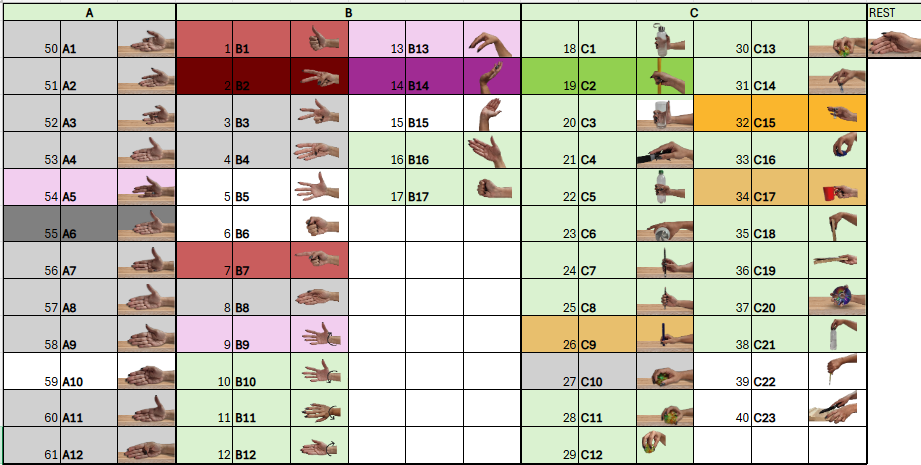

- **55:** A6 (Ring extension)
- **2:** B2 (Extension of index and middle, flexion of the others)
- **14:** B14 (Wrist extension)
- **19:** C2 (Small diameter grasp (Power grip))
- **32:** C15 (Tip pinch grasp)

## PCA analysis

In [ ]:
cluster_colors = dendro['leaves_color_list']
leaf_order = dendro['leaves']  # Orden de las hojas en el dendrograma
data_color_map = {leaf_order[i]: cluster_colors[i] for i in range(len(leaf_order))}
print("Índice de los datos originales y su color asignado:")
for index, color in sorted(data_color_map.items()):
    print(f"Dato {index}: Color {color}")
#print("Colores usados en el threshold:", cluster_colors)

- Relationship between RMS and MNF for grasp

In [ ]:
# 1. Associate colors with the relabeled values
leaf_labels = [int(label) for label in dendro['ivl']]  # Convert labels to integers
color_dict = {leaf_labels[i]: dendro['leaves_color_list'][i] for i in range(len(leaf_labels))}

# 2. Prepare the PCA data
df_plot = grouped[['RMS mean', 'MNF mean', 'RMS std', 'MNF std']].copy()
df_plot['relabeled'] = grouped.index.astype(int)  # Ensure they are integers

# 3. Create the PCA plot with dendrogram colors
plt.figure(figsize=(8, 6))

for label in df_plot['relabeled'].unique():
    subset = df_plot[df_plot['relabeled'] == label]
    mean_x, mean_y = subset['RMS mean'].values[0], subset['MNF mean'].values[0]
    
    # Get color from the dictionary
    color = color_dict.get(label, 'black')  # If not found, use black as fallback

    # Plot points
    plt.scatter(mean_x, mean_y, label=f'Relabeled {label}', color=color, edgecolor='black', s=100)

plt.xlabel('RMS Mean')
plt.ylabel('MNF Mean')
plt.title('Variability Between Movements')
plt.legend()
plt.grid()
plt.show()